# Logistic regression Assumptions

- log-odds linearity
- multicollinearity
- outliers


## Data Loading


In [18]:
import pandas as pd
import matplotlib.pyplot as plt

from python_proj.utils.util import safe_save_fig, Counter
import python_proj.utils.exp_utils as exp_utils

file_name = "dataset_transformed"
base_path = exp_utils.BASE_PATH
data_path = f"{base_path}/final_data/{file_name}.csv"
experiment_name = "general_collaborative_logit_model"
figure_base_path = f"{base_path}/figures/modelling/{file_name}/{experiment_name}"

# Meta stuff.
pr_merged_key = "PullRequestIsMerged"
ftc_key = "SubmitterIsFirstTimeContributor"
seed_counter = Counter()


# Loads dataframe.
df: pd.DataFrame = pd.read_csv(filepath_or_buffer=data_path, header=0)

# Loads first-time contributor data frame.
print(f"{len(df)=}")
print(f"{len(df.columns)=}")

# Creates sub-datasets.
metadata_fields = ["ID", "Project Name", "Submitter ID", "PR Number", "Closed At"]
dependent_fields = [pr_merged_key]
independent_fields = [
    field
    for field in df.columns
    if (field not in metadata_fields and field not in dependent_fields)
]

df.describe()

len(df)=1216221
len(df.columns)=43


,ID,Project Name,Submitter ID,PR Number,Closed At,IntraProjectSubmitterPullRequestSuccessRate,EcosystemExperienceSubmitterPullRequestSuccessRate,DependencyEcosystemExperienceSubmitterPullRequestSuccessRate,NonDependencyEcosystemExperienceSubmitterPullRequestSuccessRate,InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate,...,ln(1 + DependencyEcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + DependencyEcosystemExperienceSubmitterIssueCommentCount),ln(1 + NonDependencyEcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + NonDependencyEcosystemExperienceSubmitterIssueCommentCount),ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueCommentCount),ln(1 + WeightedEcosystemSecondOrderDegreeCentrality),ln(1 + WeightedIntraProjectSecondOrderDegreeCentrality),ln(1 + EcosystemLinkIntensity),ln(1 + IntraProjectLinkIntensity)
count,1.216221e+06,1.216221e+06,1216221.0,1216221.0,1216221.0,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,...,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06
mean,9.081164e+05,8.677039e+03,0.0,0.0,0.0,5.027905e-01,4.027001e-01,9.860918e-02,3.749753e-01,5.920373e-02,...,1.145965e-02,1.972030e-02,7.959556e-02,1.343719e-01,9.534855e-03,1.751229e-02,6.396949e-02,6.042839e-02,2.191224e-02,4.468485e-02
std,5.243531e+05,5.806587e+03,0.0,0.0,0.0,4.710578e-01,4.523420e-01,2.908001e-01,4.479160e-01,2.284681e-01,...,5.401390e-02,8.011601e-02,1.179346e-01,1.749533e-01,5.258916e-02,8.239552e-02,9.937732e-02,1.003326e-01,8.736962e-02,1.013914e-01
min,0.000000e+00,4.300000e+01,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.542500e+05,3.224000e+03,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,9.078700e+05,8.413000e+03,0.0,0.0,0.0,6.666667e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,7.753347e-02,0.000000e+00,0.000000e+00,8.438514e-03,0.000000e+00,0.000000e+00,0.000000e+00
75%,1.362318e+06,1.357000e+04,0.0,0.0,0.0,1.000000e+00,9.387755e-01,0.000000e+00,9.230769e-01,0.000000e+00,...,0.000000e+00,0.000000e+00,1.416667e-01,2.326004e-01,0.000000e+00,0.000000e+00,9.891430e-02,8.847414e-02,0.000000e+00,2.582313e-02
max,1.815970e+06,2.009400e+04,0.0,0.0,0.0,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


## Feature selection for collaborative model

Identifies all features that are not part of the collaborative model and drops those.

In [19]:
# Identifies the to-be-dropped features

from python_proj.utils.util import get_matching

has_eco_but_no_collab_pattern = (
    r"^(?!.*(?:LinkIntensity|DegreeCentrality))(?=.*Ecosystem).*"
)
dropped_fields = list(get_matching(independent_fields, has_eco_but_no_collab_pattern))

print(f"{len(dropped_fields)=}")
print(f"{dropped_fields=}")

len(dropped_fields)=20
dropped_fields=['EcosystemExperienceSubmitterPullRequestSuccessRate', 'DependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'NonDependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'ln(1 + EcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + EcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + DependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + DependencyEcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + NonDependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + NonDependencyEcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + EcosystemExperienceSubmitterIssueSubmissionCount)', 'ln(1 + EcosystemExperienceSubmitterIssueComme

In [20]:
# Drops the selected features

df = df.drop(dropped_fields, axis=1)
independent_fields = [
    field for field in independent_fields if field not in dropped_fields
]

print(f"{len(df.columns)=}")
df.describe()

len(df.columns)=23


,ID,Project Name,Submitter ID,PR Number,Closed At,IntraProjectSubmitterPullRequestSuccessRate,ln(1 + ControlPullRequestLifeTimeInMinutes),ln(1 + ControlNumberOfCommitsInPullRequest),ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator),ln(1 + IntraProjectSubmitterPullRequestSubmissionCount),ln(1 + IntraProjectSubmitterPullRequestCommentCount),ln(1 + IntraProjectSubmitterIssueSubmissionCount),ln(1 + IntraProjectSubmitterIssueCommentCount),ln(1 + WeightedEcosystemSecondOrderDegreeCentrality),ln(1 + WeightedIntraProjectSecondOrderDegreeCentrality),ln(1 + EcosystemLinkIntensity),ln(1 + IntraProjectLinkIntensity)
count,1.216221e+06,1.216221e+06,1216221.0,1216221.0,1216221.0,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06
mean,9.081164e+05,8.677039e+03,0.0,0.0,0.0,5.027905e-01,4.196918e-01,1.184120e-01,2.984402e-01,1.688730e-01,1.419525e-01,7.018853e-02,1.273611e-01,6.396949e-02,6.042839e-02,2.191224e-02,4.468485e-02
std,5.243531e+05,5.806587e+03,0.0,0.0,0.0,4.710578e-01,2.256422e-01,7.151447e-02,1.867518e-01,1.842688e-01,1.853288e-01,1.282197e-01,1.878345e-01,9.937732e-02,1.003326e-01,8.736962e-02,1.013914e-01
min,0.000000e+00,4.300000e+01,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.542500e+05,3.224000e+03,0.0,0.0,0.0,0.000000e+00,2.368024e-01,7.525668e-02,1.658279e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,9.078700e+05,8.413000e+03,0.0,0.0,0.0,6.666667e-01,4.434840e-01,7.525668e-02,2.972434e-01,9.318519e-02,0.000000e+00,0.000000e+00,0.000000e+00,8.438514e-03,0.000000e+00,0.000000e+00,0.000000e+00
75%,1.362318e+06,1.357000e+04,0.0,0.0,0.0,1.000000e+00,5.862811e-01,1.505134e-01,4.382336e-01,3.095545e-01,2.735423e-01,1.045989e-01,2.261884e-01,9.891430e-02,8.847414e-02,0.000000e+00,2.582313e-02
max,1.815970e+06,2.009400e+04,0.0,0.0,0.0,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


## Log-odds linearity


### Visual checking


untransformed


IntraProjectSubmitterPullRequestSuccessRate:
0.00    0.000000
0.10    0.500000
0.25    0.862069
0.40    0.954545
0.50    1.000000
0.60    1.000000
0.75    1.000000
0.90    1.000000
1.00    1.000000
Name: IntraProjectSubmitterPullRequestSuccessRate, dtype: float64

x=[0.0, 0.75, 0.9166666666666666, 1.0, 1.0, 1.0, 1.0, 1.0], y=[0.08350888149854074, 1.6126665000766334, 2.56093989695728, 2.557803963491896, 2.49508925157209, 2.49508925157209, 2.49508925157209, 2.49508925157209]
ln(1 + ControlPullRequestLifeTimeInMinutes):
0.00    0.001063
0.25    0.236802
0.50    0.443489
0.75    0.586287
1.00    1.000000
Name: ln(1 + ControlPullRequestLifeTimeInMinutes), dtype: float64

x=[0.1277870687664653, 0.3402738923454344, 0.5096383073097654, 0.6888808059305025], y=[1.899850992587973, 1.9012760002909048, 1.6054019300047595, 0.30682132073220164]
ln(1 + ControlNumberOfCommitsInPullRequest):
0.00    0.075257
0.25    0.075257
0.50    0.075257
0.75    0.150513
1.00    1.000000
Name: ln(1 + ControlNumberOf

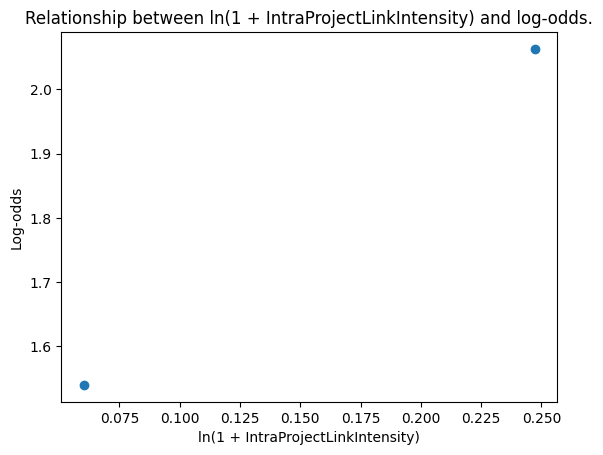

In [21]:
import regex as re
from numbers import Number
from typing import Callable, Iterator
import numpy as np
from python_proj.utils.util import tuple_chain


def test_log_linearity(
    independents: pd.DataFrame, dependent: pd.Series, transform_title: str = ""
):
    continuous_fields = independents.select_dtypes(include="number")

    all_data = pd.DataFrame()
    all_data[continuous_fields.columns] = continuous_fields.copy()
    all_data[pr_merged_key] = dependent.copy()

    for field in continuous_fields.columns:
        # Creates copy of the relevant fields.
        included = pd.DataFrame()
        included[field] = all_data[field].copy()
        included[pr_merged_key] = all_data[pr_merged_key].copy()

        # Removes data that will signifcantly skew the results.
        if re.match(r".*SuccessRate.*", field):
            # TODO: Figure out what to do with success rate.
            # We can't properly test the log-linearity with the current data.
            # count_field = field[:-len('SuccessRate')] + "SubmissionCount"
            stripped_field = field[: -len("SuccessRate")]
            count_field = f"ln(1 + {stripped_field}SubmissionCount)"
            included[count_field] = all_data[count_field].copy()
            included = included[included[count_field] > 0]
            perc_quantiles = [0, 0.1, 0.25, 0.4, 0.5, 0.6, 0.75, 0.9, 1]
        elif re.match(r".*LinkIntensity.*", field):
            included = included[included[field] > 0]
            perc_quantiles = [0, 0.5, 1]
        else:
            included = included[included[field] > 0]
            perc_quantiles = [0, 0.25, 0.5, 0.75, 1]

        # Calculates quantiles.
        quantiles = included[field].quantile(perc_quantiles)
        print(f"{field}:")
        print(quantiles)
        print()

        x = []
        y = []
        skip_flag = False
        for r_start, r_end in tuple_chain(list(quantiles)):
            quant_data: pd.DataFrame = included[
                (included[field] >= r_start) & (included[field] <= r_end)
            ]
            # quant_mean = quant_data[field].mean()
            quant_mean = quant_data[field].median()
            merged_entries = quant_data[quant_data[pr_merged_key] == True]
            probability = len(merged_entries) / len(quant_data)
            if probability == 1:
                skip_flag = True
                break
            log_odds = np.log(probability / (1 - probability))
            x.append(quant_mean)
            y.append(log_odds)

        if skip_flag:
            print(f"Skipped {field} because of division by zero.")
            continue

        print(f"{x=}, {y=}")

        plt.clf()
        plt.scatter(x, y)
        plt.title(f"Relationship between {field} and log-odds.")
        plt.xlabel(field)
        plt.ylabel("Log-odds")

        output_path = (
            f"{figure_base_path}/log-odds-independence/{transform_title}/{field}"
        )
        safe_save_fig(output_path)


def scale(_df: pd.DataFrame, scaled_fields: pd.Series):
    scaled_df = _df.copy()

    for feature in scaled_fields:
        feature_min = scaled_df[feature].min()
        feature_max = scaled_df[feature].max()
        feature_delta = feature_max - feature_min

        scaled_df[feature] = (
            scaled_df[feature].subtract(feature_min).divide(feature_delta)
        )

    return scaled_df


def test_log_linearity_with_transforms(
    transforms: Iterator[Callable[[Number], Number]],
    independents: pd.DataFrame,
    dependent: pd.Series,
    figure_subfolder: str,
):
    continuous_fields = independents.select_dtypes(include="number")
    for transform in transforms:
        print(f"\n{transform.__name__}")
        transformed_independents = continuous_fields.copy()
        for field in transformed_independents.columns:
            transformed_independents[field] = transformed_independents[field].apply(
                transform
            )
            transformed_independents = scale(transformed_independents, [field])

        test_log_linearity(
            transformed_independents,
            dependent,
            f"{figure_subfolder}/{transform.__name__}",
        )


def untransformed(value):
    return value


def ln_transform(value):
    return np.log(1 + value)


def sqrt_transform(value):
    return np.sqrt(1 + value)


def cbrt_transform(value):
    return np.cbrt(1 + value)


def reciprocal_transform(value):
    return 1 / (1 + value)


def squared_transform(value):
    return value**2


def ln_ln_transform(value):
    return np.log(1 + np.log(1 + value))


def ln_eps_transform(value):
    return np.log(0.1 + value)


def ln_eps_e2_transform(value):
    return np.log(0.01 + value)


def ln_eps_e3_transform(value):
    return np.log(0.001 + value)


def cubed_transform(value):
    return value**3


def ln_complement(value):
    return np.log(1.0 + (1.0 - value))


def ln_eps_complement(value):
    return np.log(0.001 + (1.0 - value))


def ln_eps_e5_complement(value):
    return np.log(0.00001 + (1.0 - value))


def compl_squared_compl(value):
    return 1.0 - ((1.0 - value) ** 2)


transforms = [
    untransformed,
    # ln_transform,
    # sqrt_transform,
    # cbrt_transform,
    # reciprocal_transform,
    # ln_complement,
    # ln_eps_complement,
    # compl_squared_compl,
    # squared_transform,
    # cubed_transform,
    # ln_ln_transform,
    # ln_eps_e2_transform,
    # ln_eps_e3_transform,
    # ln_eps_e5_complement
]


# Full model.
independents = df[independent_fields]
dependent = df[pr_merged_key]
test_log_linearity_with_transforms(
    transforms, independents, dependent, figure_subfolder=""
)

## Multicolinearity


### Dropped fields

The following are fields that were dropped to tackle multicollinearity.
The following two subsections: variance inflation factor, and spearman correlation were used to identify the features that were removed.

In [22]:
# Standardized list of multicollinear fields.
multicollinear_fields = [
    # Confounding factor
    "ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)",
    # Correlating Controls
    # "ControlIntegratedBySameUser",
    # "ControlPullRequestHasComments",
    # Intra link intensity
    "ControlIntegratedBySameUser",
    "ln(1 + IntraProjectLinkIntensity)",
    # Intra experience
    "IntraProjectSubmitterPullRequestSuccessRate",
    "SubmitterIsFirstTimeContributor",
    "ln(1 + IntraProjectSubmitterIssueCommentCount)",
    # "ln(1 + IntraProjectSubmitterIssueSubmissionCount)",
    "ln(1 + IntraProjectSubmitterPullRequestCommentCount)",
    "ln(1 + IntraProjectSubmitterPullRequestSubmissionCount)",
    "ln(1 + WeightedIntraProjectSecondOrderDegreeCentrality)",
]

print(
    f"Removing {len(multicollinear_fields)} / {len(independent_fields)} fields to account for multicollinearity."
)

Removing 9 / 17 fields to account for multicollinearity.


In [23]:
# Drops fields.

logit_df = df[independent_fields].drop(multicollinear_fields, axis=1)

print(f"{len(logit_df)=}")
print(f"{len(logit_df.columns)=}")
print(f"{logit_df.columns=}")

len(logit_df)=1216221
len(logit_df.columns)=8
logit_df.columns=Index(['ControlPullRequestHasComments',
       'ControlPullRequestHasCommentByExternalUser',
       'ControlHasHashTagInDescription',
       'ln(1 + ControlPullRequestLifeTimeInMinutes)',
       'ln(1 + ControlNumberOfCommitsInPullRequest)',
       'ln(1 + IntraProjectSubmitterIssueSubmissionCount)',
       'ln(1 + WeightedEcosystemSecondOrderDegreeCentrality)',
       'ln(1 + EcosystemLinkIntensity)'],
      dtype='object')


### Variance Inflation Factor

The following identify problematic features using VIF.

In [24]:
# Replaces binary values with numeric variants so VIF can be calculated.

from statsmodels.stats.outliers_influence import variance_inflation_factor

value_mapper = {False: 0, True: 1}

binary_fields = logit_df.select_dtypes(exclude="number")
print(f"{len(binary_fields.columns)=}")
for feature in binary_fields:
    logit_df[feature] = logit_df[feature].replace(value_mapper)

len(binary_fields.columns)=3


In [25]:
# Calculates VIF

vif_df = pd.DataFrame()
vif_df["variable"] = logit_df.columns
vif_df["VIF"] = [
    variance_inflation_factor(logit_df.values, i) for i in range(logit_df.shape[1])
]

print(vif_df)

                                            variable       VIF
0                      ControlPullRequestHasComments  3.632383
1         ControlPullRequestHasCommentByExternalUser  1.903321
2                     ControlHasHashTagInDescription  1.542765
3        ln(1 + ControlPullRequestLifeTimeInMinutes)  3.975235
4        ln(1 + ControlNumberOfCommitsInPullRequest)  2.914261
5  ln(1 + IntraProjectSubmitterIssueSubmissionCount)  1.320962
6  ln(1 + WeightedEcosystemSecondOrderDegreeCentr...  1.465335
7                     ln(1 + EcosystemLinkIntensity)  1.170331


In [26]:
# Identifies problematic fields, according to VIF.

VIF_THRESHOLD = 5

problematic_vif = vif_df[vif_df["VIF"] >= VIF_THRESHOLD]

print(f"{VIF_THRESHOLD}")
print(f"Problematic VIF fields: {len(problematic_vif)}.")
print("Problematic VIF scores:\n", problematic_vif)

5
Problematic VIF fields: 0.
Problematic VIF scores:
 Empty DataFrame
Columns: [variable, VIF]
Index: []


### Spearman Correlation

The following calculates the pairwise spearman correlation, to identify what problematic (groups of) features are.

In [27]:
# Calculates Spearman correlation between variables.

import json

corr = logit_df.corr(method="spearman")
coof_threshold = 0.5
print(f"{coof_threshold=}")

correlating_fields = []
for rowIndex, row in corr.iterrows():
    for columnIndex, coof in row.items():
        if columnIndex <= rowIndex:
            continue
        if abs(coof) < coof_threshold:
            continue
        correlating_fields.append([columnIndex, rowIndex, coof])
correlating_fields = [list(entry) for entry in correlating_fields]

print("Correlating pairs:\n", json.dumps(correlating_fields, indent=2))

coof_threshold=0.5
Correlating pairs:
 [
  [
    "ControlPullRequestHasComments",
    "ControlPullRequestHasCommentByExternalUser",
    0.5018126876524234
  ]
]


In [28]:
# Generates transitive closure of correlating fields;
# i.e., it identifies clusters of correlating features.

from typing import List, Set

transitive_closures: List[Set[str]] = []

# Iterates through all correlating fields.
for field_a, field_b, _ in correlating_fields:
    was_added = False
    # Sees if one of the components is part of a transitive closure.
    for transitive_closure in transitive_closures:
        if field_a in transitive_closure or field_b in transitive_closure:
            was_added = True
            transitive_closure.update((field_a, field_b))
    # Adds new closure if they are not.
    if not was_added:
        new_set = set()
        new_set.update((field_a, field_b))
        transitive_closures.append(new_set)

# Prepares the closures to be printed.
transitive_closures = [sorted(list(closure)) for closure in transitive_closures]

print(
    "Transitive closure of correlating pairs:\n",
    json.dumps(transitive_closures, indent=2),
)

Transitive closure of correlating pairs:
 [
  [
    "ControlPullRequestHasCommentByExternalUser",
    "ControlPullRequestHasComments"
  ]
]


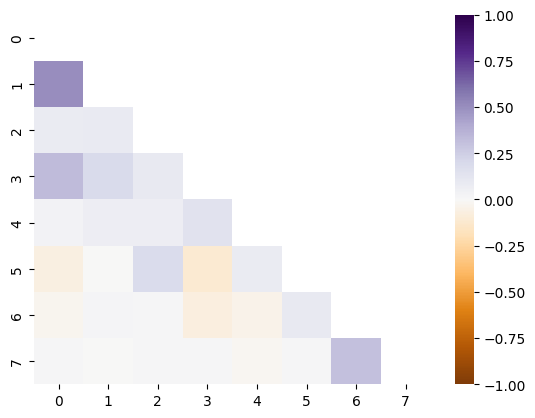

In [29]:
# Plots correlation as seaborn plot.

import seaborn as sb

tick_labels = list(range(len(vif_df)))
rows, cols = corr.shape
mask = np.invert(np.tril(np.ones((rows, cols), dtype=bool), k=-1))
dataplot = sb.heatmap(
    corr,
    cmap="PuOr",
    xticklabels=tick_labels,
    yticklabels=tick_labels,
    mask=mask,
    vmin=-1,
    vmax=1,
)

[[0, "ControlPullRequestHasComments"], [1, "ControlPullRequestHasCommentByExternalUser"], [2, "ControlHasHashTagInDescription"], [3, "ln(1 + ControlPullRequestLifeTimeInMinutes)"], [4, "ln(1 + ControlNumberOfCommitsInPullRequest)"], [5, "ln(1 + IntraProjectSubmitterIssueSubmissionCount)"], [6, "ln(1 + WeightedEcosystemSecondOrderDegreeCentrality)"], [7, "ln(1 + EcosystemLinkIntensity)"]]


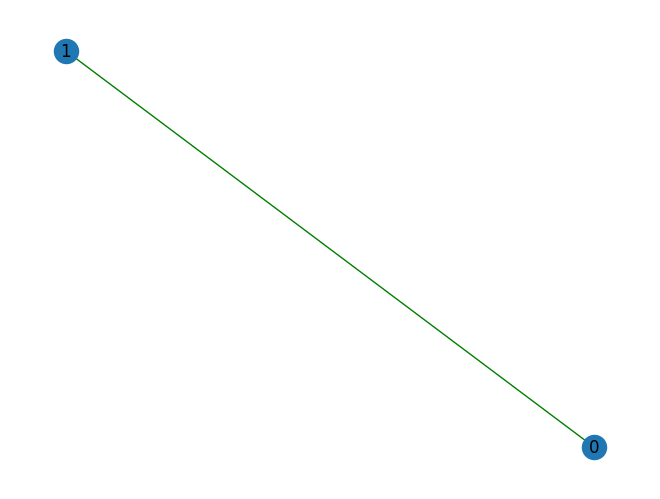

In [30]:
# Plots correlations as a graph.

import networkx as nx
import matplotlib.pyplot as plt

fields = list(logit_df.columns)
enumerated_list = list(enumerate(fields))
ids = []
edge_colors = []
for source, target, coof in correlating_fields:
    source_idx = fields.index(source)
    target_idx = fields.index(target)
    ids.append((source_idx, target_idx))
    edge_colors.append("red" if coof < 0 else "green")

# Create an empty graph
graph = nx.Graph()

# Add edges to the graph from the list of tuples
graph.add_edges_from(ids)

pos = nx.spring_layout(graph, k=0.4)
nx.draw(graph, pos, with_labels=True, edge_color=edge_colors)

if len(correlating_fields) == 0:
    print("When there are no correlating fields, the figure is supposed to be empty.")

output_path = f"{figure_base_path}/correlating_fields.png"
safe_save_fig(output_path)

print(json.dumps(enumerated_list))

## Outliers

Using cook's distance.


In [31]:
import statsmodels.api as sm
import scipy

X_constant = sm.add_constant(logit_df)

# Use GLM method for logreg here so that we can retrieve the influence measures
logit_results = sm.GLM(
    df[pr_merged_key], X_constant, family=sm.families.Binomial()
).fit()

# Get influence measures
influence = logit_results.get_influence()

# Obtain summary df of influence measures
summ_df = influence.summary_frame()

# Filter summary df to Cook's distance values only
diagnosis_df = summ_df[["cooks_d"]]

# Set Cook's distance threshold
cook_threshold = 4 / len(logit_df)

# Append absolute standardized residual values
diagnosis_df["std_resid"] = scipy.stats.zscore(logit_results.resid_pearson)
diagnosis_df["std_resid"] = diagnosis_df["std_resid"].apply(lambda x: np.abs(x))

# Find observations which are BOTH outlier (std dev > 3) and highly influential
extreme = diagnosis_df[
    (diagnosis_df["cooks_d"] > cook_threshold) & (diagnosis_df["std_resid"] > 3)
]


# Show top 5 highly influential outlier observations
extreme.sort_values("cooks_d", ascending=False).head(10)

/tmp/ipykernel_6591/2984006829.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diagnosis_df["std_resid"] = scipy.stats.zscore(logit_results.resid_pearson)
/tmp/ipykernel_6591/2984006829.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diagnosis_df["std_resid"] = diagnosis_df["std_resid"].apply(lambda x: np.abs(x))


,cooks_d,std_resid
340952,0.000170,6.691892
518708,0.000158,6.292982
370261,0.000139,4.198128
1033190,0.000134,4.612453
301312,0.000133,3.351407
309475,0.000133,4.274033
157922,0.000132,3.859414
453405,0.000132,5.130459
450746,0.000131,7.726598
576114,0.000129,5.947539


cook_threshold=3.2889002904098957e-06
Found outliers: 25327 / 1216221 (2.082%)


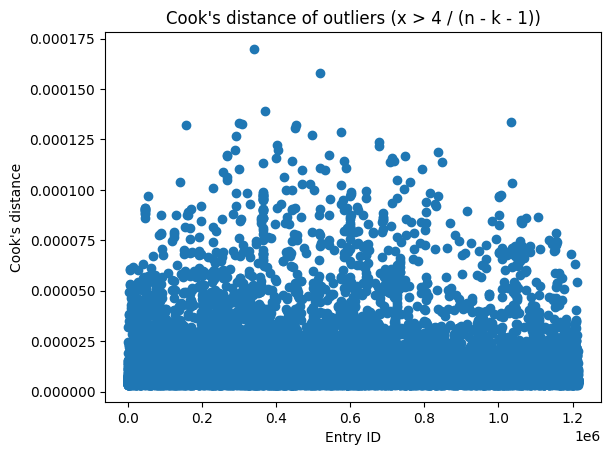

In [32]:
cook_threshold = 4 / (len(logit_df) - len(logit_df.columns) - 1)
print(f'{cook_threshold=}')
print(
    f"Found outliers: {len(extreme)} / {len(logit_df)} ({100 * len(extreme)/len(logit_df):.03f}%)"
)

plt.title("Cook's distance of outliers (x > 4 / (n - k - 1))")
plt.scatter(extreme.index, extreme["cooks_d"])
plt.xlabel("Entry ID")
plt.ylabel("Cook's distance")

output_path = f"{figure_base_path}/cooks_outliers.png"
safe_save_fig(output_path)

Removes outliers

In [33]:
logit_df = logit_df.drop(extreme.index)
tested_dependents = dependent.drop(extreme.index)

print(f"{len(logit_df)=}")

len(logit_df)=1190894


In [34]:
# Re-scales the data to account for removed outliers.

from wmutils.pandas.transforms import min_max_scale

tested_numeric_predictors = [
    col
    for col in logit_df.select_dtypes(include="number").columns
    if col not in metadata_fields
]
logit_df = min_max_scale(logit_df, tested_numeric_predictors)

# Model Creation

Creates a simple mixed effect logistic regression model.

In [35]:
from statsmodels.regression.mixed_linear_model import MixedLM

# Selects relevant project names.
pn_key = "Project Name"
tested_projects = df[pn_key].copy()
tested_projects = tested_projects[logit_df.index]

# Creates model.
mixed_model = MixedLM(
    tested_dependents,
    logit_df,
    tested_projects,
).fit()

mixed_model.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                              Mixed Linear Model Regression Results
=================================================================================================
Model:                        MixedLM           Dependent Variable:           PullRequestIsMerged
No. Observations:             1190894           Method:                       REML               
No. Groups:                   20049             Scale:                        0.1136             
Min. group size:              1                 Log-Likelihood:               -448364.9649       
Max. group size:              688               Converged:                    Yes                
Mean group size:              59.4                                                               
-------------------------------------------------------------------------------------------------
                                                     Coef.  Std.Err.    z     P>|z| [0.025 0.975]
-------------------------------------------------------------------------------------------------
ControlPullRequestHasComments                        -0.118    0.001 -138.718 0.000 -0.120 -0.116
ControlPullRequestHasCommentByExternalUser           -0.006    0.001   -7.199 0.000 -0.008 -0.005
ControlHasHashTagInDescription                        0.040    0.001   55.086 0.000  0.039  0.042
ln(1 + ControlPullRequestLifeTimeInMinutes)          -0.435    0.002 -260.669 0.000 -0.439 -0.432
ln(1 + ControlNumberOfCommitsInPullRequest)           0.124    0.005   25.828 0.000  0.114  0.133
ln(1 + IntraProjectSubmitterIssueSubmissionCount)     0.202    0.003   62.529 0.000  0.196  0.208
ln(1 + WeightedEcosystemSecondOrderDegreeCentrality)  0.167    0.004   44.783 0.000  0.159  0.174
ln(1 + EcosystemLinkIntensity)                        0.322    0.004   74.975 0.000  0.313  0.330
Group Var                                             1.044    0.032                             
=================================================================================================

"""

###

In [36]:
import os

# outputs results to a csv.

summ = mixed_model.summary()

fields = summ.tables[1]
output = pd.DataFrame()
for field in fields.columns:
    output[f"Dependency Model: {field}"] = fields[field]

dir_name = f"{base_path}/coefs/{file_name}/{experiment_name}"
output_path = f"{dir_name}/coefs.csv"
if not os.path.exists(dir_name):
    os.makedirs(dir_name)

output.to_csv(output_path)

In [37]:
import datetime

print(datetime.datetime.now())

2024-03-08 09:57:29.129964
